In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
import time

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True

## Import and Pad Data

In [2]:
## Import Data

# sequence column lists are in string format so use literal eval to reconvert
all_event_sequence = pd.read_csv('../Data/OpenStack/all_event_sequences.csv', header=0, index_col=None, converters={"sequence": literal_eval})
kmeans_event_sequence = pd.read_csv('../Data/OpenStack/kmean_event_sequences.csv', header=0, index_col=None, converters={"sequence": literal_eval})

# Anomaly Labels (Response)
labels = all_event_sequence['anomaly']

print(f'Anomalous: {sum(labels)} / {len(labels)}')


Anomalous: 4 / 158336


<AxesSubplot:xlabel='sequence', ylabel='Count'>

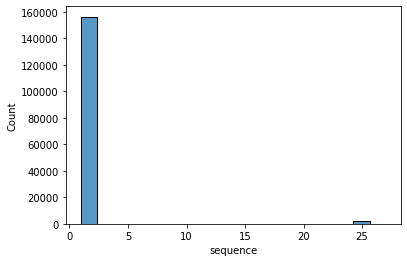

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# view length of sequences
lens = all_event_sequence.sequence.apply(lambda x: len(x))

sns.histplot(lens)

In [4]:
## remove single sequences (they're not sequences)
all_event_sequence = all_event_sequence.loc[lens > 2, :].reset_index(drop = True)
kmeans_event_sequence = kmeans_event_sequence.loc[lens > 2, :].reset_index(drop = True)

# Pad sequences (Predictor)
padded_all = pad_sequences(all_event_sequence.sequence, padding='post')
padded_km = pad_sequences(kmeans_event_sequence.sequence, padding='post')

# new labels
labels = all_event_sequence['anomaly']

print(f'Anomalous: {sum(labels)} / {len(labels)}')

Anomalous: 4 / 2067


## Split Data

In [5]:
# Split Train 0.5
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.50)
for train_index, rest_index in sss.split(padded_all, labels):
    x_train, x_other = padded_all[train_index], padded_all[rest_index]
    y_train, y_other = labels[train_index], labels[rest_index]

# Split Val 0.25 / Test 0.25
for val_index, test_index in sss.split(x_other, y_other):
    x_val, x_test = padded_all[val_index], padded_all[test_index]
    y_val, y_test = labels[val_index], labels[test_index]

# Standardize to arrays
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)


# Check proportions
trn, val, tst = len(y_train), len(y_val), len(y_test)
tot = sum([trn, val, tst])
print(f'Train: {round(trn/tot, 2)} ({trn})',
      f'Val: {round(val/tot, 2)} ({val})',
      f'Test: {round(tst/tot, 2)}({tst})',
      f'Total: {1} ({tot})', sep = '\n')

print(sum(y_train), sum(y_val), sum(y_test))

Train: 0.5 (1033)
Val: 0.25 (517)
Test: 0.25(517)
Total: 1 (2067)
2 1 1


## Build Data Loaders

In [6]:
BATCH_SIZE = 100


################################
## Create Tensor Datasets 
################################
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))


################################
## Dataset Iterators:
################################
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True)

print('Training Dimensions\n')
for data_cat in [train_loader, val_loader, test_loader]:
    for batch in data_cat:
        print(f'Sequence matrix size: {batch[0].size()}')
        print(f'Target vector size: {batch[1].size()}\n')
        break


Training Dimensions

Sequence matrix size: torch.Size([100, 27])
Target vector size: torch.Size([100])

Sequence matrix size: torch.Size([100, 27])
Target vector size: torch.Size([100])

Sequence matrix size: torch.Size([100, 27])
Target vector size: torch.Size([100])



## PyTorch LSTM Model
And associated functions
***

In [8]:
# "vocabulary" size

all_events = all_event_sequence.sequence.apply(pd.Series).stack().reset_index(drop = True)
kmean_events = kmeans_event_sequence.sequence.apply(pd.Series).stack().reset_index(drop = True)

print('Unique Events:', len(all_events.unique()))
print('Unique Events w kmeans:', len(kmean_events.unique()))


Unique Events: 1723
Unique Events w kmeans: 10


In [9]:
################################
## ARCHITECTURAL PARAMETERS
################################
VOCAB_SIZE_all_events = 1723
VOCAB_SIZE_kmean_events = 10
OUTPUT_SIZE = 1
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
CLIP = 5

################################
## MODEL
################################
class Anomaly_Detector(nn.Module):
    def __init__(self,  vocab_size, output_size, embedding_dim, hidden_dim, batch_size, n_layers, bidirectinoal=True, drop_prob=0):
        super().__init__()

        # Params
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.bidir = 2 if bidirectinoal==True else 1
        self.hidden_dim = hidden_dim
        
        # Layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            batch_first=True,
                            num_layers=n_layers, 
                            dropout=drop_prob,  
                            bidirectional=True)

        self.fc = nn.Linear(hidden_dim*self.bidir, output_size) # multiply hidden by 2 if using bidirectinoality
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, sequences): 
        sequences = sequences.long().to(DEVICE) # [batch_size, seq_len]
        embedded = self.dropout(self.embedding(sequences)) # [batch_size, seq_length, embedded_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded) 
        # lstm_out = [batch_size, seq_length, hidden_dim * num_directions]
        # hidden = [num layers * num directions,  batch size, hidden_dim]
        # cell = [num layers * num directions, batch size, hidden_dim]
        
        if self.bidir==2:
            # Concat the final forward and barckward hidden layers + apply dropout if specified
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        elif self.bidir==1: 
            hidden = self.dropout(hidden[-1,:,:])

        out = self.activation(self.fc(hidden).reshape(-1))

        return out


################################
## DEFINE ACCURACY FUNCTION
################################
def compute_binary_accuracy(model, data_loader, device, print_output=False):
    model.eval()
    all_preds = torch.empty(0).cuda()
    all_labs = torch.empty(0).cuda()

    with torch.no_grad():
        for inpt, labs in data_loader:

            inpt, labs = inpt.cuda(), labs.cuda()
            all_labs = torch.cat((all_labs, labs), 0).reshape(-1)

            logits = model(inpt)
            predicted_labels = (logits > 0.5).reshape(-1)
            all_preds = torch.cat((all_preds, predicted_labels), 0).reshape(-1)

        # Move to CPU
        all_preds, all_labs = all_preds.cpu(), all_labs.cpu()
        accuracy = round(accuracy_score(all_labs, all_preds), 4) # of all predictions, how many were correct?
        precision = round(precision_score(all_labs, all_preds), 4) # of predicted anomalies, how many were correct?
        recall = round(recall_score(all_labs, all_preds), 4) # of all true anomalies, how many were recovered?

        if print_output:
            print(confusion_matrix(all_labs, all_preds), end = '\n\n')
            print('Accuracy:', accuracy) 
            print('Precision:', precision) 
            print('Recall:', recall)
            return None
        
        return accuracy, precision, recall

################################
## DEFINE TRAINING + TESTING FUNCTION
################################
def training_function():
    print('\nSTARTING TRAINING\n')
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):

        model.train()
        print(f'Current Epoch: {epoch+1}')

        for batch_idx, batch_data in enumerate(train_loader):

            inpt, labs = batch_data[0], batch_data[1].to(DEVICE)

            optimizer.zero_grad() # Clear gradients from last batch

            logits = model(inpt) # Compute logits (ie. final hidden state)

            # Compute cost
            cost = criterion(logits.squeeze(), labs.float())
            cost.backward()

            # Use clip_grad_norm to prevent exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()

            # Log
            if not batch_idx % 100:
                print (f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                       f'BCE Cost: {cost:.4f}')

        with torch.set_grad_enabled(False):
            model.eval()
            print(f'Epoch Comleted: {epoch+1}'
                  f'\n\twith training accuracy: {compute_binary_accuracy(model, train_loader, DEVICE)[0]:.4f}%'
                  f'\n\tand validation accuracy: {compute_binary_accuracy(model, val_loader, DEVICE)[0]:.4f}%')

        print(f'\tTime elapsed: {(time.time() - start_time)/60:.2f} min\n')

    ## Final Test Accuracy
    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
    print('----------------------------------------------')
    print('Final Test Accuracy/Precision/Recall : ', compute_binary_accuracy(model, test_loader, DEVICE))
    print('----------------------------------------------')

In [10]:
# Make models reproducible

RANDOM_SEED = 123


## Training Vanilla LSTM

In [17]:
# using vocab of 2000+

DEVICE = 'cpu'
#torch.manual_seed(RANDOM_SEED)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 4
NUM_LAYERS = 1
DROPOUT = 0
BIDIRECTIONAL = False

## INITIALIZE MODEL
model = Anomaly_Detector(VOCAB_SIZE_all_events, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(DEVICE)

## LOSS AND OPTIMIZER
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## TRAIN/TEST
training_function()


STARTING TRAINING

Current Epoch: 1


RuntimeError: cuda runtime error (710) : device-side assert triggered at ..\aten\src\THC\THCCachingHostAllocator.cpp:278

In [18]:
def compute_binary_accuracy(model, data_loader, device, print_output=False):
    model.eval()
    all_preds = torch.empty(0).cuda()
    all_labs = torch.empty(0).cuda()

    with torch.no_grad():
        for inpt, labs in data_loader:

            inpt, labs = inpt.cuda(), labs.cuda()
            all_labs = torch.cat((all_labs, labs), 0).reshape(-1)

            logits = model(inpt)
            predicted_labels = (logits > 0.5).reshape(-1)
            all_preds = torch.cat((all_preds, predicted_labels), 0).reshape(-1)

        # Move to CPU
        all_preds, all_labs = all_preds.cpu(), all_labs.cpu()
        accuracy = accuracy_score(all_labs, all_preds) # of all predictions, how many were correct?
        precision = precision_score(all_labs, all_preds) # of predicted anomalies, how many were correct?
        recall = recall_score(all_labs, all_preds) # of all true anomalies, how many were recovered?

        if print_output:
            print(confusion_matrix(all_labs, all_preds), end = '\n\n')
            print('Accuracy:', accuracy) 
            print('Precision:', precision) 
            print('Recall:', recall)
            return None
        
        return accuracy, precision, recall
    
compute_binary_accuracy(model, test_loader, DEVICE,print_output=True)

RuntimeError: cuda runtime error (710) : device-side assert triggered at ..\aten\src\THC\THCCachingHostAllocator.cpp:278

In [19]:
# using vocab of 20

torch.manual_seed(RANDOM_SEED)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 3
NUM_LAYERS = 1
DROPOUT = 0
BIDIRECTIONAL = False

## INITIALIZE MODEL
model = Anomaly_Detector(VOCAB_SIZE_kmean_events, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(DEVICE)

## LOSS AND OPTIMIZER
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## TRAIN/TEST
training_function()

RuntimeError: CUDA error: device-side assert triggered

## Training 2 Layer LSTM

In [7]:
# Params: 2 Layer

torch.manual_seed(RANDOM_SEED)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 3
NUM_LAYERS = 2
DROPOUT = 0
BIDIRECTIONAL = False

## INITIALIZE MODEL
model = Anomaly_Detector(VOCAB_SIZE, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(DEVICE)

## LOSS AND OPTIMIZER
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_function()


STARTING TRAINING

Current Epoch: 1
Batch 000/402 | BCE Cost: 0.6993
Batch 100/402 | BCE Cost: 0.0863
Batch 200/402 | BCE Cost: 0.1178
Batch 300/402 | BCE Cost: 0.0860
Batch 400/402 | BCE Cost: 0.0934
Epoch Comleted: 1
	with training accuracy: 0.9815%
	and validation accuracy: 0.9808%
	Time elapsed: 1.85 min

Current Epoch: 2
Batch 000/402 | BCE Cost: 0.0537
Batch 100/402 | BCE Cost: 0.0155
Batch 200/402 | BCE Cost: 0.0071
Batch 300/402 | BCE Cost: 0.0072
Batch 400/402 | BCE Cost: 0.0089
Epoch Comleted: 2
	with training accuracy: 0.9981%
	and validation accuracy: 0.9982%
	Time elapsed: 3.88 min

Current Epoch: 3
Batch 000/402 | BCE Cost: 0.0061
Batch 100/402 | BCE Cost: 0.0168
Batch 200/402 | BCE Cost: 0.0101
Batch 300/402 | BCE Cost: 0.0088
Batch 400/402 | BCE Cost: 0.0032
Epoch Comleted: 3
	with training accuracy: 0.9989%
	and validation accuracy: 0.9990%
	Time elapsed: 5.93 min

Total Training Time: 5.93 min
----------------------------------------------
Final Test Accuracy/Precisi

In [8]:
# Params 1 Layer / Bidirectional

torch.manual_seed(RANDOM_SEED)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 3
NUM_LAYERS = 1
DROPOUT = 0
BIDIRECTIONAL = True

## INITIALIZE MODEL
model = Anomaly_Detector(VOCAB_SIZE, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(DEVICE)

## LOSS AND OPTIMIZER
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_function()


STARTING TRAINING

Current Epoch: 1
Batch 000/402 | BCE Cost: 0.7502
Batch 100/402 | BCE Cost: 0.1390
Batch 200/402 | BCE Cost: 0.1049
Batch 300/402 | BCE Cost: 0.0787
Batch 400/402 | BCE Cost: 0.0833
Epoch Comleted: 1
	with training accuracy: 0.9815%
	and validation accuracy: 0.9809%
	Time elapsed: 0.90 min

Current Epoch: 2
Batch 000/402 | BCE Cost: 0.1048
Batch 100/402 | BCE Cost: 0.0760
Batch 200/402 | BCE Cost: 0.0169
Batch 300/402 | BCE Cost: 0.0080
Batch 400/402 | BCE Cost: 0.0135
Epoch Comleted: 2
	with training accuracy: 0.9980%
	and validation accuracy: 0.9982%
	Time elapsed: 1.79 min

Current Epoch: 3
Batch 000/402 | BCE Cost: 0.0170
Batch 100/402 | BCE Cost: 0.0036
Batch 200/402 | BCE Cost: 0.0027
Batch 300/402 | BCE Cost: 0.0169
Batch 400/402 | BCE Cost: 0.0020
Epoch Comleted: 3
	with training accuracy: 0.9991%
	and validation accuracy: 0.9991%
	Time elapsed: 2.68 min

Total Training Time: 2.68 min
----------------------------------------------
Final Test Accuracy/Precisi

In [8]:
# Params: 2 layer / Bidirectional

torch.manual_seed(RANDOM_SEED)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 3
NUM_LAYERS = 2
DROPOUT = 0
BIDIRECTIONAL = True

## INITIALIZE MODEL
model = Anomaly_Detector(VOCAB_SIZE, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(DEVICE)

## LOSS AND OPTIMIZER
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_function()

## See confusion matrix
compute_binary_accuracy(model, test_loader, DEVICE, print_output=True)


STARTING TRAINING

Current Epoch: 1
Batch 000/402 | BCE Cost: 0.7074
Batch 100/402 | BCE Cost: 0.0932
Batch 200/402 | BCE Cost: 0.1304
Batch 300/402 | BCE Cost: 0.0753
Batch 400/402 | BCE Cost: 0.0239
Epoch Comleted: 1
	with training accuracy: 0.9816%
	and validation accuracy: 0.9813%
	Time elapsed: 2.35 min

Current Epoch: 2
Batch 000/402 | BCE Cost: 0.0371
Batch 100/402 | BCE Cost: 0.0210
Batch 200/402 | BCE Cost: 0.0154
Batch 300/402 | BCE Cost: 0.0086
Batch 400/402 | BCE Cost: 0.0021
Epoch Comleted: 2
	with training accuracy: 0.9983%
	and validation accuracy: 0.9982%
	Time elapsed: 4.21 min

Current Epoch: 3
Batch 000/402 | BCE Cost: 0.0077
Batch 100/402 | BCE Cost: 0.0051
Batch 200/402 | BCE Cost: 0.0034
Batch 300/402 | BCE Cost: 0.0010
Batch 400/402 | BCE Cost: 0.0008
Epoch Comleted: 3
	with training accuracy: 0.9995%
	and validation accuracy: 0.9996%
	Time elapsed: 6.05 min

Total Training Time: 6.05 min
----------------------------------------------
Final Test Accuracy/Precisi